In [2]:
# import libraries
from importlib import reload
from data import northWindConnector
import numpy as np

In [3]:
reload(northWindConnector);

## Investigate data

Below we make a connection to the database.

In [4]:
db = northWindConnector.DbConnector()

The code snippet below prints tables with their column names.

In [5]:
tables = db.list_tables()
for table in tables:
    print(f'\n==={table}===\n')
    columns = db.list_column_names(table)
    for column in columns:
        print(column)


===Employee===

Id
LastName
FirstName
Title
TitleOfCourtesy
BirthDate
HireDate
Address
City
Region
PostalCode
Country
HomePhone
Extension
Photo
Notes
ReportsTo
PhotoPath

===Category===

Id
CategoryName
Description

===Customer===

Id
CompanyName
ContactName
ContactTitle
Address
City
Region
PostalCode
Country
Phone
Fax

===Shipper===

Id
CompanyName
Phone

===Supplier===

Id
CompanyName
ContactName
ContactTitle
Address
City
Region
PostalCode
Country
Phone
Fax
HomePage

===Order===

Id
CustomerId
EmployeeId
OrderDate
RequiredDate
ShippedDate
ShipVia
Freight
ShipName
ShipAddress
ShipCity
ShipRegion
ShipPostalCode
ShipCountry

===Product===

Id
ProductName
SupplierId
CategoryId
QuantityPerUnit
UnitPrice
UnitsInStock
UnitsOnOrder
ReorderLevel
Discontinued

===OrderDetail===

Id
OrderId
ProductId
UnitPrice
Quantity
Discount

===CustomerCustomerDemo===

Id
CustomerTypeId

===CustomerDemographic===

Id
CustomerDesc

===Region===

Id
RegionDescription

===Territory===

Id
TerritoryDescription

# Question 3: Is there a difference in mean sales between Sales Managers and Sales Representatives?

We are interested in a difference in mean sales between sales managers and sales representatives. Below we load the relevant data from the database.

In [6]:
query = """
SELECT e.id, e.Title, o.Id AS OrderId, od.UnitPrice, od.Quantity, od.Discount
FROM OrderDetail AS od
JOIN 'Order' AS o ON o.Id = od.OrderId
JOIN Employee AS e ON o.EmployeeId = e.Id
WHERE e.Title IN ('Sales Manager', 'Sales Representative')
"""
df = db.load_query_as_df(query)

In [7]:
df.shape

(1654, 6)

Below we define a function that will compute the total price of the items described in a row of the dataframe.

In [8]:
def compute_product_total(price, quantity, discount):
    total = price*(1 - discount)*quantity
    return total

Next we use the function above to add a `Total` column to the dataframe.

In [9]:
df['Total'] = df.apply(lambda x: compute_product_total(x.UnitPrice, x.Quantity, x.Discount), axis=1)

In [10]:
df.shape

(1654, 7)

Next we group sales by employee.

In [11]:
grouped = df[['OrderId', 'Title', 'Total']].groupby(['OrderId', 'Title']).sum().reset_index()

In [12]:
grouped.shape

(630, 3)

Now we make our samples.

In [13]:
managers = np.array(df.loc[df['Title'] == 'Sales Manager', 'Total'])
reps = np.array(df.loc[df['Title'] == 'Sales Representative', 'Total'])

Text(0.5, 1.0, 'Price Distributions for sales by Managers ($N_m =$ 117) and Representatives ($N_r =$ 1537)')

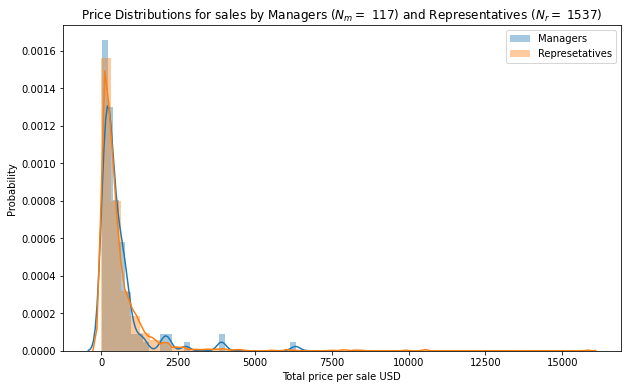

In [14]:
import seaborn as sns
import matplotlib.pyplot as plt
plt.figure(figsize = (10,6))
sns.distplot(managers)
sns.distplot(reps)
plt.xlabel('Total price per sale USD')
plt.ylabel('Probability')
plt.legend(['Managers', 'Represetatives'])
plt.title(f'Price Distributions for sales by Managers ($N_m =$ {len(managers)}) and Representatives ($N_r =$ {len(reps)})')

## Welch's T-Test
H0: There is no difference between the mean sales for sales managers and sales representatives. 
HA: There is a difference between the mean sales sales managers and sales representatives.

### Verifying hypotheses.
Welch's t-test assumes that the sampling distributions for the sample means are normally distributed. While prices are clearly skewed right, the sample sizes are large enough that the Central Limit Theorem ensures that the sampling distributions will be sufficiently close to the normal distribution. 

In [15]:
from scipy import stats
stats.ttest_ind(managers, reps, equal_var=False)

Ttest_indResult(statistic=0.0008430356383237651, pvalue=0.9993285461525043)

## Conclusion

We fail to reject the Null Hypothesis. We are not able to detect any significant difference between the mean sales for Managers and Representatives.

<img src='../images/meme.jpeg' width='500'/>